# Sigma(R) Reconstruction

Lensing is non-local because it depends on structure at all scales below $R$. This notebook demonstrates how to compute the _reconstructed_ $\Sigma(R)_Y$ profile, which is different than the true surface mass density of a halo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cluster_toolkit as ct
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [3]:
#Output path for plots
outpath = "../docs/source/figures/"

In [4]:
#This is our halo mass and concentration, and our one cosmology
Mass = 1e14 #Msun/h
conc = 5 #concentration
Omega_m = 0.3 #The only cosmological parameter we need

In [5]:
klin = np.loadtxt("test_data/klin.txt")
Plin = np.loadtxt("test_data/plin.txt") #linear power spectrum
knl = np.loadtxt("test_data/knl.txt")
Pnl = np.loadtxt("test_data/pnl.txt") #nonlinear power spectrum

In [6]:
#Radii of the 3D profiles
Nr = 1000
r = np.logspace(-2, 3, Nr) #3D distance, Mpc/h comoving

In [7]:
#1-halo is NFW and the 2-halo term is based off the matter correlation function
xi_nfw = ct.xi.xi_nfw_at_r(r, Mass, conc, Omega_m)
xi_mm = ct.xi.xi_mm_at_r(r, knl, Pnl)
#Calculate the halo bias for this halo
bias = ct.bias.bias_at_M(Mass, klin, Plin, Omega_m)
#Complete the 2-halo term
xi_2halo = ct.xi.xi_2halo(bias, xi_mm)
xi_hm = ct.xi.xi_hm(xi_nfw, xi_2halo)

In [8]:
#Compute an NFW profile
NR = 1000
Rp = np.logspace(-2, 2.4, NR) #Mpc/h comoving
Sigma  = ct.deltasigma.Sigma_at_R(Rp, r, xi_hm, Mass, conc, Omega_m)
DeltaSigma = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, Mass, conc, Omega_m)
#Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(Rp, Mass, conc, Omega_m)
#DeltaSigma_nfw = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma_nfw, Mass, conc, Omega_m)

In [9]:
#Compute the reconstructed Sigma(R)_Y profile
Y = ct.sigma_reconstruction.Sigma_REC_from_DeltaSigma(Rp, DeltaSigma)

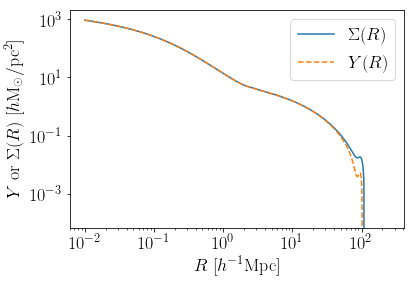

In [10]:
plt.loglog(Rp, Sigma, label=r"$\Sigma(R)$")
plt.loglog(Rp[:-1], Y, "--", label=r"$Y(R)$")
#plt.yscale("symlog")
plt.ylabel(r"$Y\ {\rm or}\ \Sigma(R)\ [h{\rm M_\odot}/{\rm pc}^2]$")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.legend()
#plt.savefig("sigma_reconstructed.png", dpi=300, bbox_inches="tight")

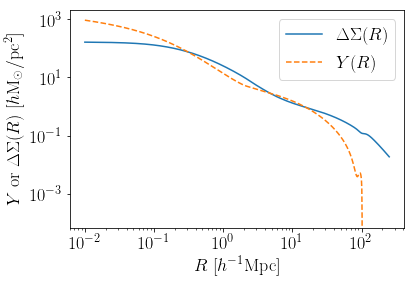

In [11]:
plt.loglog(Rp, DeltaSigma, label=r"$\Delta\Sigma(R)$")
plt.loglog(Rp[:-1], Y, "--", label=r"$Y(R)$")
#plt.yscale("symlog")
plt.ylabel(r"$Y\ {\rm or}\ \Delta\Sigma(R)\ [h{\rm M_\odot}/{\rm pc}^2]$")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
plt.legend()
#plt.savefig("deltasigma_reconstructed.png", dpi=300, bbox_inches="tight")

# Covariance test

The matrix that transformed $\Delta\Sigma$ to $Y$ is written as ${\bf T} = -2S-I$, where $S$ is a matrix with small negative elements. Converting between the covariance matrix of $\Delta\Sigma$ and $Y$ is given by
$$
C_Y = {\bf T}C_{\Delta\Sigma}{\bf T}^T\,,
$$
where $\ ^T$ is a transpose (apologies for the notation). Let's test what the fractional change in the covariance is between the two.

In [12]:
dlnR = np.log(Rp[0]) - np.log(Rp[1])
#T matrix is N-1 (cols) x N (rows)
T = np.zeros((len(Rp)-1,len(Rp)))
for i in range(0, len(Rp)-1):
    T[i,i] = -1. #Identity part
    for j in range(i, len(Rp)):
        T[i,j] -= 2*dlnR
        if j==i or j == len(Rp)-1: #Supress last terms
            T[i,j] += dlnR
        continue
    continue

(1000, 1000) (999, 999)


Text(0.5, 0, '$R\\ [h^{-1}{\\rm Mpc}]$')

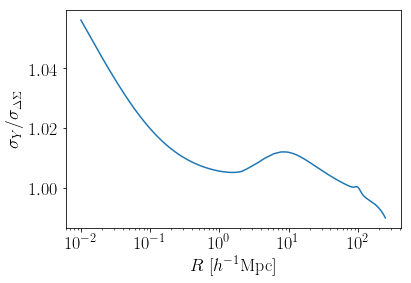

In [13]:
C = np.diag(0.1*DeltaSigma) #10% uncertainty
CY = np.dot(T, np.dot(C, T.T))
print(C.shape, CY.shape)
std_ratio = np.sqrt(CY.diagonal() / C[:-1,:-1].diagonal())
plt.plot(Rp[:-1], std_ratio)
plt.xscale("log")
plt.ylabel(r"$\sigma_{Y} / \sigma_{\Delta\Sigma}$")
plt.xlabel(r"$R\ [h^{-1}{\rm Mpc}]$")
#plt.savefig("uncertainty_ratio.png", dpi=300, bbox_inches="tight")